In [35]:
# real data
import pandas as pd
url = 'https://gist.githubusercontent.com/tijptjik/9408623/raw/b237fa5848349a14a14e5d4107dc7897c21951f5/wine.csv'
df = pd.read_csv(url,index_col=0,parse_dates=[0])
df

,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
Wine,,,,,,,,,,,,,
1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835


In [148]:

import numpy as np
def data_batch(data, batch_size, seed = 123):
    n = data.shape[0]
    p = data.shape[1]
    if n % batch_size !=0:
        print('%d data dropped during batching' % (n%batch_size))
    sample_size = (n // batch_size)*batch_size
        
    #shuffle
    np.random.seed(seed)
    idx = np.arange(n)
    np.random.shuffle(idx)
    n_batch = n//batch_size
    data = data[idx]
    data = data[:sample_size].reshape(batch_size, p, n_batch)
    return(data, n_batch)

def is_pos_def(A):
    '''function to check if matrix is positive definite'''
    return np.all(np.linalg.eigvals(A) > 0)

def sghmc(gradU, eps, C, Minv, theta_0, V_hat, epochs, burns, data, batch_size, seed = 123):
    
    '''Define SGHMC as dscribed in
    Stochastic Gradient Hamilton Monte Carlo, ICML 2014
    Tianqi Chen, Emily B. Fox, Carlos Guestrin.
    
    n: number of observations in data
    p: dimension of parameters
    
    Inputs:
        gradU: function with parameter(theta, X, y), gradient of U
        
        eps: learning rate
        
        C: friction matrix, with shape (p,p)
        
        Minv: Mass matrix, with shape (p,p)
        
        theta_0: initial value for sampling
        
        V_hat: estimated covariance matrix of stochastic gradient noise
        
        epochs: number of epochs to perform
        
        burns: number of epochs to drop
        
        batch_size: size of a minibatch in an iteration
        
        seed: seed for random generation, default 123
        
    
    Output:
        theta_samp: np.array sampled thetas
    '''
    
    
    np.random.seed(seed)
    
    p = theta_0.shape[0]
    n = data.shape[0]
    
    theta_samp = np.zeros((p, epochs))
    theta_samp[:,0] = theta_0
    
    B_hat = 0.5*eps*V_hat
    
    if not is_pos_def(2*(C-B_hat)*eps):
        print("error: noise term is not positive definite")
        return
    
    sqrt_noise = np.linalg.cholesky(2*(C-B_hat)*eps)
    
    sqrtM = np.linalg.cholesky(np.linalg.inv(Minv))
    r = sqrtM@np.random.normal(size = p).reshape(p, -1)
    
    dat_batch, nbatches = data_batch(data, batch_size)
    for i in range(epochs-1):
        
        theta = theta_samp[:,i]
        r = sqrtM@np.random.normal(size = p).reshape(p, -1)
        
        for batch in range(nbatches):
            theta = theta + (eps*Minv@r).ravel()
            gradU_batch = gradU(theta, dat_batch[:,:, batch], n, batch_size).reshape(p, -1)
            r = r-eps*gradU_batch - eps*C@Minv@r + sqrt_noise@np.random.normal(size = p).reshape(p, -1)
            
        theta_samp[:,i+1] = theta
            
    return theta_samp[:, burns:]

In [8]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn import preprocessing, svm 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 

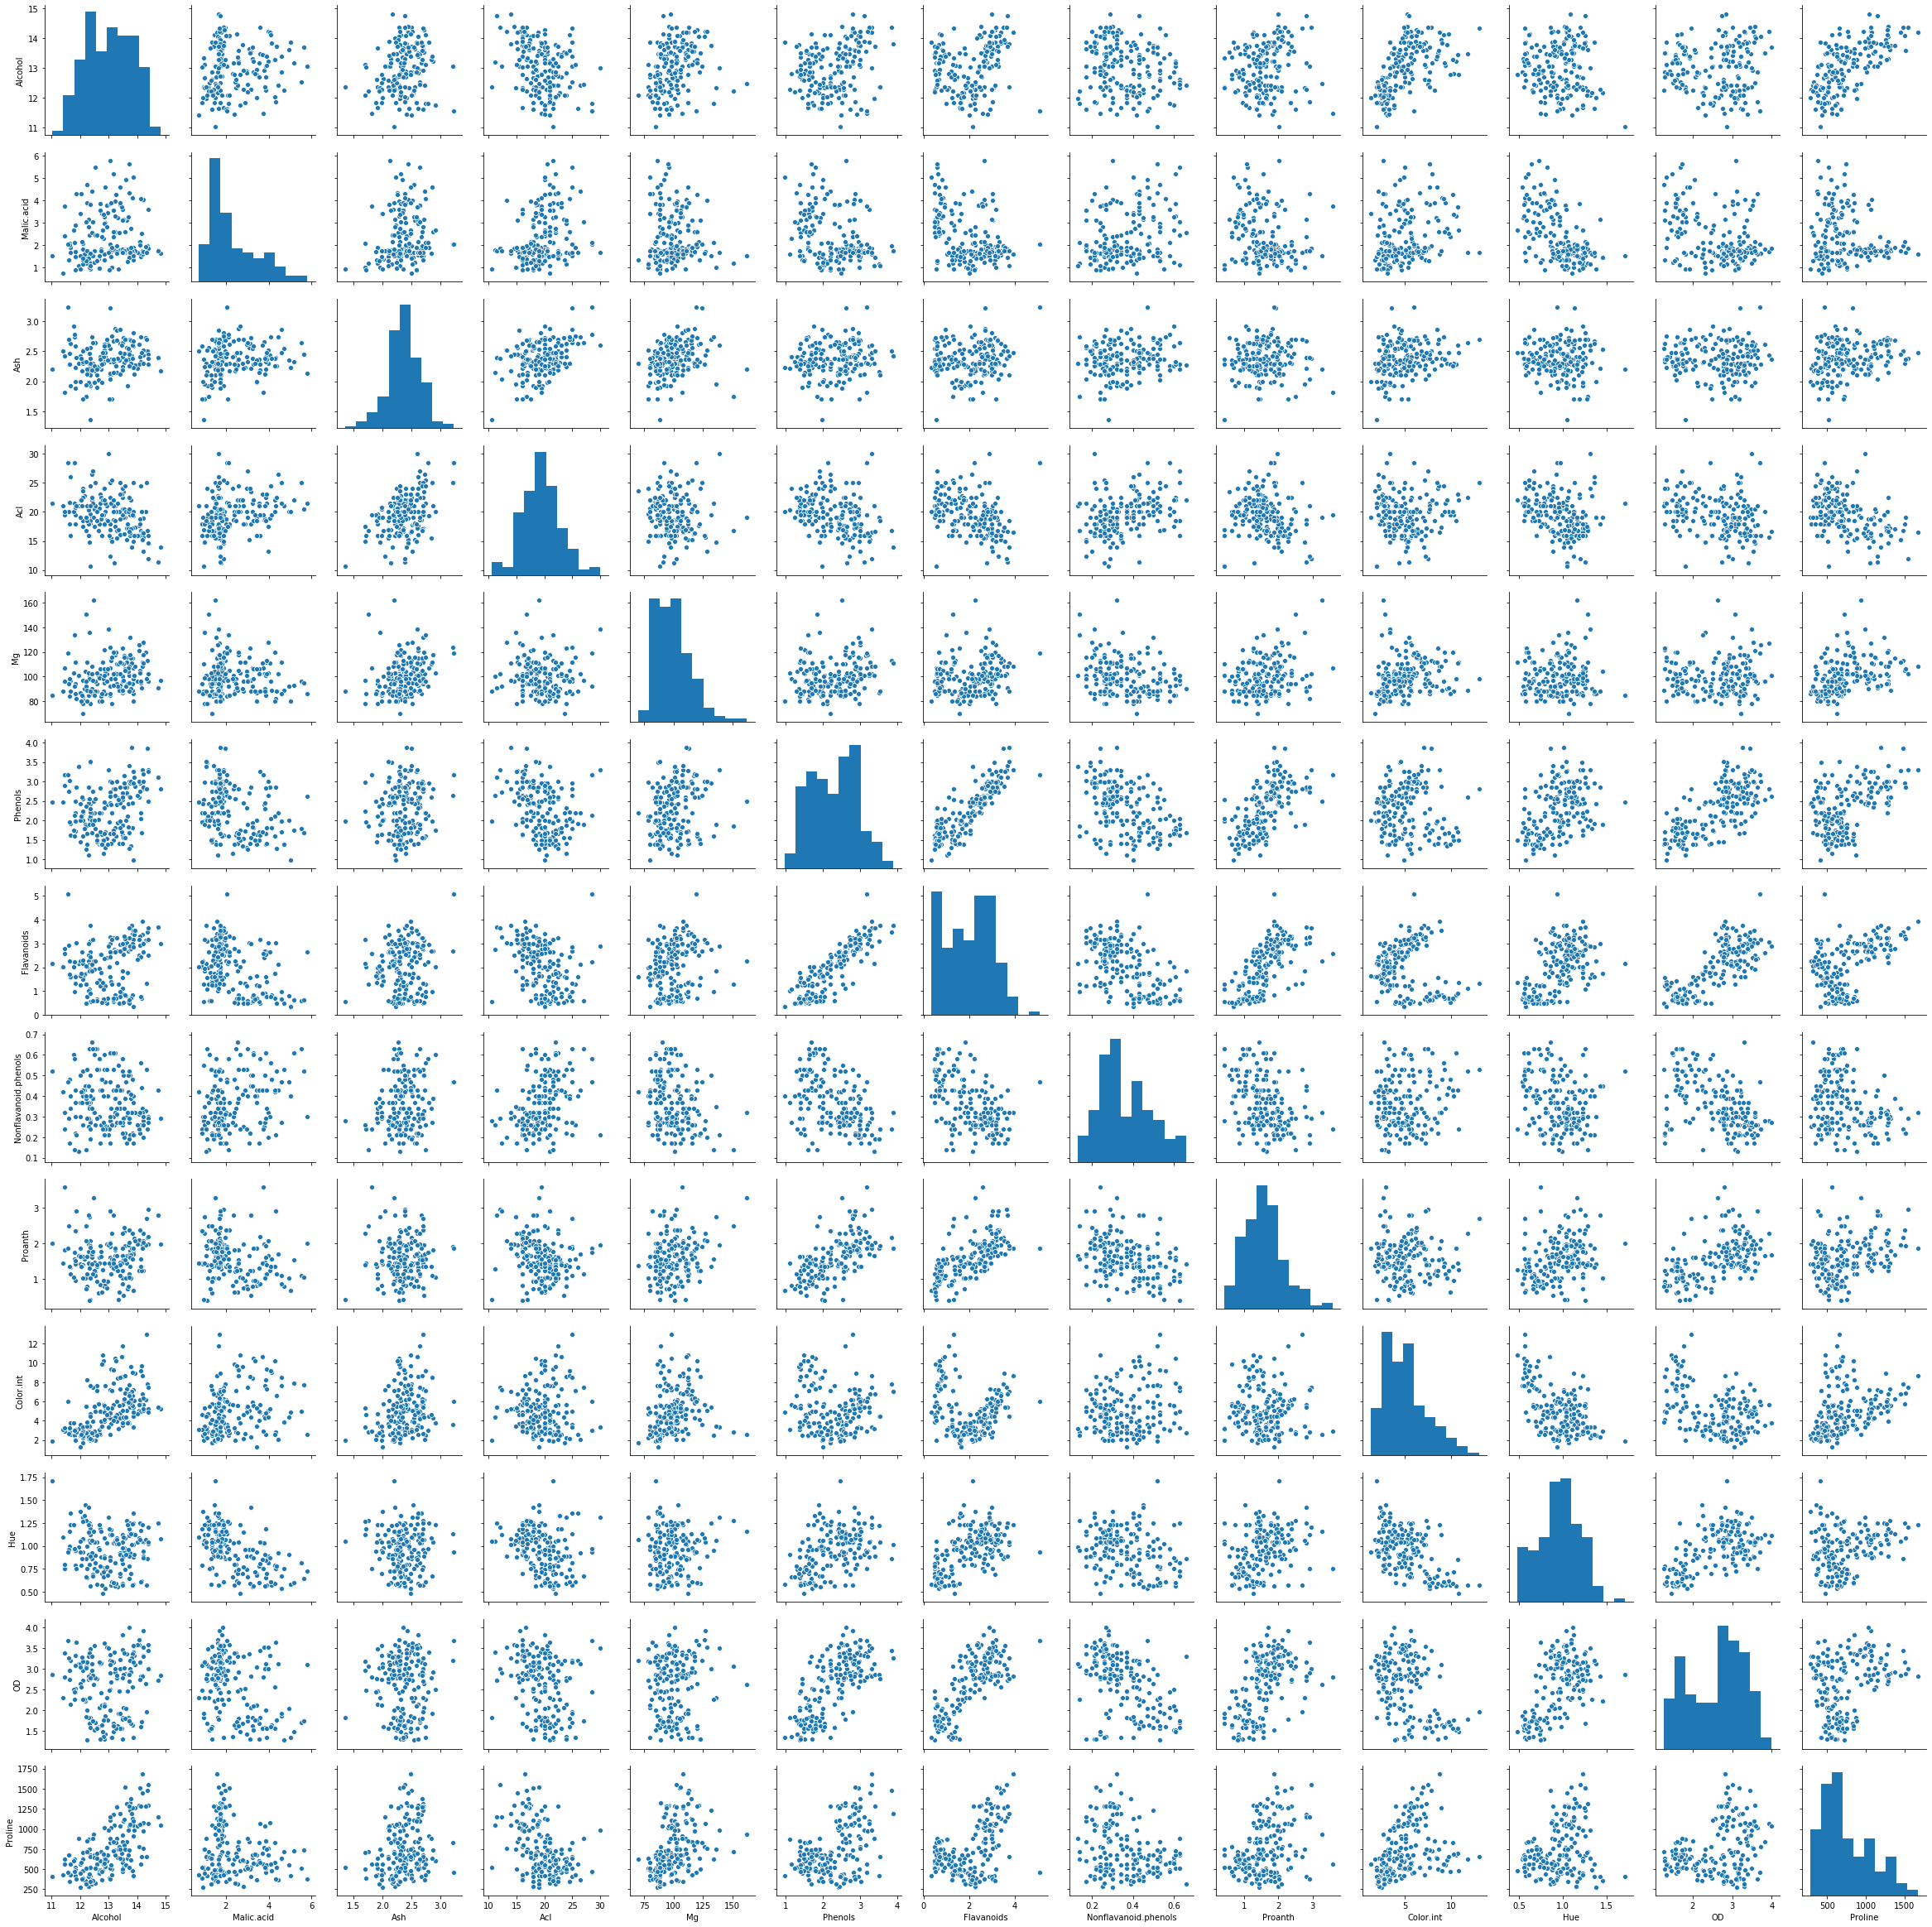

In [97]:
sns.pairplot(df)

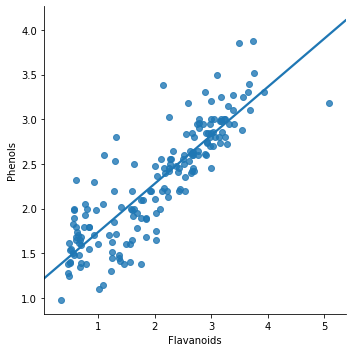

In [103]:
sns.lmplot(x ="Flavanoids", y ="Phenols", data = df, order = 1, ci = None)

In [9]:
import sys
!{sys.executable} -m pip install autograd #install package to calculate gradient

In [173]:
var = np.eye(178)*1.5
v_= np.linalg.inv(var)
data = np.c_[df["Flavanoids"], df["Phenols"]]
np.random.seed(123)
n = len(df)
theta_0 = np.array([2.5, 3])
p = theta_0.shape[0]
eps = 0.1
C = np.eye(2)
V = V_hat = np.eye(2)*4
batch_size = 2
epochs = 4000
burns = 200

def gradU(theta, data, n, batch_size):
    '''noisy gradient from paper fig1'''
    x = np.c_[np.ones(batch_size), data[:,0]]
    y = data[:,1][:,None]
    return np.c_[-1/1.5*np.sum(y-theta[0]+theta[1]*x),-1/1.5*np.sum((y-theta[0]+theta[1]*x)*x)]-theta

In [174]:
sim_mn = sghmc(gradU, eps, C, np.eye(2), theta_0, V_hat, epochs, burns, data, batch_size)

/Users/lindsaywu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in matmul
/Users/lindsaywu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in matmul


In [175]:
sim_mn

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])